This script creates a graph for each provider in england, as well as creating a example graph for two specific providers two compare some possible analytics that can be used. in this project.  

In [1]:
import pandas as pd
import pyodbc
import numpy as np
import csv
import matplotlib.pyplot as plt
from scipy.stats.contingency import association
import networkx as nx
from node2vec import Node2Vec
from operator import itemgetter


c:\Users\hshami\Documents\hsma\1\.conda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#Pulls the data from SQL database
def sql_call(OrgCode):
  orgcode = OrgCode
  conn = pyodbc.connect()



  inv_correlations = pd.read_sql_query()

  inv_correlations2 = pd.read_sql_query()


  inv_correlations_combined = pd.concat([inv_correlations,inv_correlations2], ignore_index = True)
  return inv_correlations_combined

In [4]:
# edge list
def create_list(OrgCode):
    inv_correlations = sql_call(OrgCode)
   
    inv_correlations['InvestigationDescriptionCat'] = inv_correlations['InvestigationDescription'].astype('category')
    inv_correlations['InvestigationDescriptionCatCode'] = inv_correlations['InvestigationDescriptionCat'].cat.codes
    investigations_list = max(inv_correlations.InvestigationDescriptionCatCode) + 1
    servMove = np.zeros((investigations_list, investigations_list))
    singles = np.zeros((1))
    clientIDUni = inv_correlations.EC_Ident.unique()
    for ID in clientIDUni:
        mask = inv_correlations.EC_Ident == ID
        cInvestigationTeam = inv_correlations[mask].InvestigationDescriptionCatCode
        n_Investigation = len(cInvestigationTeam)
        if (n_Investigation > 1):
            for j in range(0, (n_Investigation - 1)):
                servMove[int(cInvestigationTeam.iloc[j]),int(cInvestigationTeam.iloc[j + 1])] +=1
        else:
            singles = np.vstack((singles,ID))
    edges = np.zeros((1,3))              
    lenRow = servMove.shape[0]           
    for i in range (0,lenRow):           
        for j in range(0,lenRow):
            if (int(servMove[j, i]) > 0):
                rowData = np.array([[j,i, int(servMove[j, i])]])
                edges = np.vstack((edges,rowData))
    edges = edges.astype(int)
    edges = edges[1:edges.shape[0], :]
    lenEdge = edges.shape[0]
    edgeType = np.repeat("Directed", lenEdge)
    edgeid = np.arange(0, lenEdge)
    edges = np.vstack((edges[:,0], edges[:,1], edgeType, edgeid, edges[:,2]))
    edges = np.transpose(edges)
    edgesdf = pd.DataFrame(edges, columns = ['Source', 'Target', 'Type', 'Id', 'Weight'])
    #edgesdf.to_csv('edge_list_corrected.csv', sep=',', index=False)
    return edgesdf

In [5]:
#Function to creat the graph
def create_graph(nodeData, edgeData):

    ## Initiate the graph object
    G = nx.Graph()
    
    ## Tranform the data into the correct format for use with NetworkX
    #Node tuples (ID, dict of attributes)
    idList = nodeData['ID'].tolist()
    labels =  pd.DataFrame(nodeData['Label'])
    labelDicts = labels.to_dict(orient='records')
    nodeTuples = [tuple(r) for r in zip(idList,labelDicts)]
    
    # Edge tuples (Source, Target, dict of attributes)
    sourceList = edgeData['Source'].tolist()
    targetList = edgeData['Target'].tolist()
    weights = pd.DataFrame(edgeData['Weight'])
    weightDicts = weights.to_dict(orient='records')
    edgeTuples = [tuple(r) for r in zip(sourceList,targetList,weightDicts)]
    
    ## Add the nodes and edges to the graph
    G.add_nodes_from(nodeTuples)
    G.add_edges_from(edgeTuples)
    
    return G

In [6]:
#Creates two graphs to compare later on in the script
nodes = pd.read_csv('node_list.csv', low_memory=False)
edges = create_list('')
G = create_graph(nodes, edges)

nodes1 = pd.read_csv('node_list.csv', low_memory=False)
edges1 = create_list('')
G1 = create_graph(nodes1, edges1)

C:\Users\hshami\AppData\Local\Temp\198\ipykernel_10584\1688280370.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  inv_correlations = pd.read_sql_query("""
C:\Users\hshami\AppData\Local\Temp\198\ipykernel_10584\1688280370.py:43: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  inv_correlations2 = pd.read_sql_query("""
C:\Users\hshami\AppData\Local\Temp\198\ipykernel_10584\1688280370.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  inv_correlations = pd.read_sql_query("""
C:\Users\hshami\AppData\Local\Temp\198\ipykernel

In [ ]:
#creates a list of OrgCodes to loop through and creates edge list for each provider
org_list = pd.read_csv("org_list.csv", header=0)

for o in org_list.RTE:
    edges = create_list(o)
    edges.to_csv('edge_list/edge_list_' + o + '.csv', sep=',', index=False)

In [47]:
#pulls in that edge list to understand the most "important" investigation for each provider. 
org_list = pd.read_csv("org_list.csv", header=0)
nodes = pd.read_csv('node_list.csv', low_memory=False)
Hub = pd.DataFrame(columns=['OrgCode', 'Hub'])
index = 0
for o in org_list.RTE:
    Hub.at[index, 'OrgCode'] = o
    edges = pd.read_csv('edge_list/edge_list_' + o + '.csv', sep=',')
    G = create_graph(nodes, edges)
   # print(list(nx.find_cliques(G)))
    (largest_hub, degree) = sorted(G.degree(), key=itemgetter(1))[-1]
    Hub.at[index, 'Hub'] = largest_hub
    index += 1
   # print(largest_hub)
Hub

,OrgCode,Hub
0,RJR,9.0
1,RPA,27.0
2,RJE,29.0
3,RH5,25.0
4,RCF,36.0
...,...,...
120,RQM,14.0
121,RBD,6.0
122,RXN,19.0
123,RK5BC,6.0


In [ ]:
#create graph for select test provider to see some comparison techniques
pos = nx.kamada_kawai_layout(G) 
G.remove_edges_from(nx.selfloop_edges(G))
G.remove_nodes_from(list(nx.isolates(G)))
plot = nx.draw(G, pos,  node_size=100, with_labels=True, font_size=10, width = 1)
plt.savefig('test.png', dpi=300, bbox_inches='tight')

In [ ]:
list(nx.find_cliques(G))

In [ ]:
list(nx.find_cliques(G1))

30


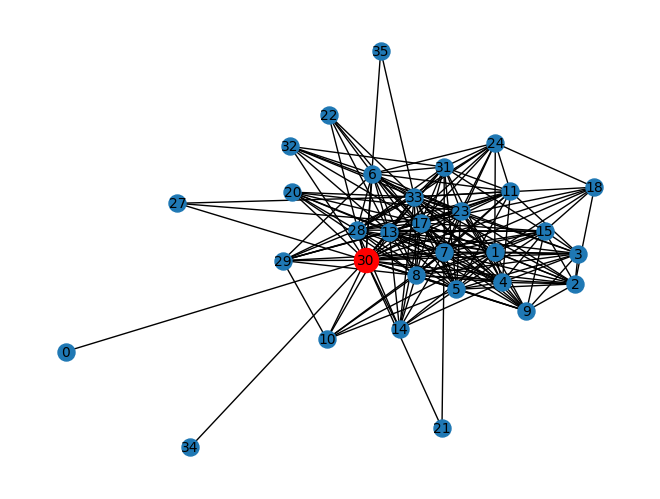

In [11]:
#This set of code is to generate the graph with the most important node highlighted in this section the most important is the most connected
node_and_degree = G.degree()
(largest_hub, degree) = sorted(node_and_degree, key=itemgetter(1))[-1]
hub_ego = nx.ego_graph(G, largest_hub)
print(largest_hub)
seed = 20532

# Draw graph
pos = nx.spring_layout(hub_ego, seed=seed)  # Seed layout for reproducibility
hub_ego.remove_edges_from(nx.selfloop_edges(G))
hub_ego.remove_nodes_from(list(nx.isolates(G)))
nx.draw(hub_ego, pos,node_size=150, with_labels=True, font_size=10)

# Draw ego as large and red
options = {"node_size": 300, "node_color": "r"}
nx.draw_networkx_nodes(hub_ego, pos, nodelist=[largest_hub], **options)
plt.show()

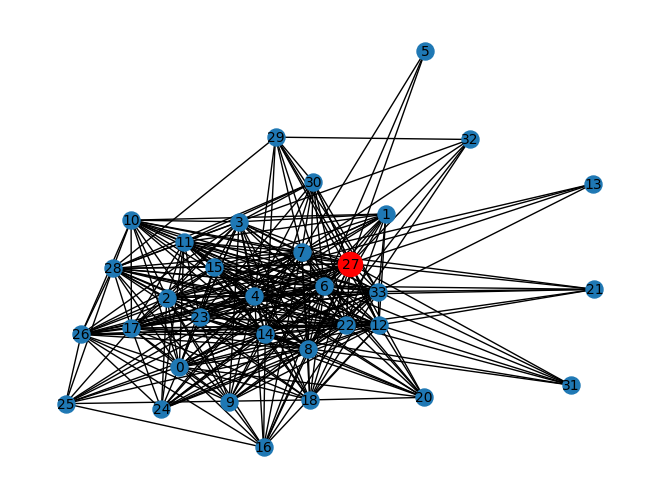

In [13]:
#Doing the same but for another provider
node_and_degree = G1.degree()
(largest_hub, degree) = sorted(node_and_degree, key=itemgetter(1))[-1]
hub_ego = nx.ego_graph(G1, largest_hub)
seed = 20532

# Draw graph
pos = nx.spring_layout(hub_ego, seed=seed)  # Seed layout for reproducibility
hub_ego.remove_edges_from(nx.selfloop_edges(G1))
hub_ego.remove_nodes_from(list(nx.isolates(G1)))
nx.draw(hub_ego, pos,node_size=150, with_labels=True, font_size=10)

# Draw ego as large and red
options = {"node_size": 300, "node_color": "r"}
nx.draw_networkx_nodes(hub_ego, pos, nodelist=[largest_hub], **options)
plt.show()